In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
# import matplotlib;matplotlib.rcParams['text.usetex'] = True
# import matplotlib;matplotlib.rcParams['font.size'] = 16
# import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import math
import scipy as sp
import numpy as np
import climin
import pylab as pb
from matplotlib import pyplot as plt
np.random.seed(1)

In [6]:
import pandas as pd
data = pd.read_csv("../data/2014-2017.csv")
data["Date"] = pd.to_datetime(data["Date"])

In [10]:
crime_list = data.groupby('Primary Type').count()["ID"].sort_values(ascending=False).reset_index()

Time series class, here u initalize the class by feeding it a dataset.  Then you can call either weekly or monthly to aggragate the data by week or by month. 

In [83]:
class timeseries():
    def __init__(self, data):
        self.data=data
        
    def sample(self, pct):
        k = np.ceil(self.X.shape[0]*pct).astype(int)
        self.known_indices = np.random.permutation(range(self.X.shape[0]))[:k]
        self.known_X = self.X[self.known_indices]
        self.known_Y = self.Y[self.known_indices]
        
    def weekly(self, k_tasks):
        self.trainx = []
        self.trainy = []
        self.testx = []
        self.testy = []
        tasks = []
        for i in range(k_tasks):
            ctype = crime_list["Primary Type"][i]
            tasks.append(ctype)
            cdata = self.data[self.data['Primary Type']==ctype].dropna(subset = ['District'])
            yearsince = cdata["Date"].dt.year-min(cdata["Date"].dt.year)
            cdata["week"] = cdata["Date"].dt.week+52*yearsince
            weekly_data = cdata.groupby(["week"]).count()["ID"].reset_index()

            train_set = weekly_data[weekly_data["week"]<=150]
            test_test = weekly_data[weekly_data["week"]>150]
            
            X = train_set[["week"]].values
            X = X.reshape((len(X),1)).astype(float)
            Y = train_set["ID"].values
            Y = Y.reshape((len(Y),1))
            self.trainx.append(X)
            self.trainy.append(Y)

            Xt = test_test[["week"]].values
            Xt = Xt.reshape((len(Xt),1)).astype(float)
            Yt = test_test["ID"].values
            Yt = Yt.reshape((len(Yt),1))
            self.testx.append(Xt)
            self.testy.append(Yt)
    
    def monthly(self, k_tasks):
        self.trainx = []
        self.trainy = []
        self.testx = []
        self.testy = []

        tasks = []
        for i in range(k_tasks):
            ctype = crime_list["Primary Type"][i]
            tasks.append(ctype)
            cdata = self.data[self.data['Primary Type']==ctype].dropna(subset = ['District'])
            yearsince = cdata["Date"].dt.year-min(cdata["Date"].dt.year)
            cdata["month"] = cdata["Date"].dt.month+12*yearsince
            monthly_data = cdata.groupby(["month"]).count()["ID"].reset_index()

            train_set = monthly_data[monthly_data["month"]<=35]
            test_test = monthly_data[monthly_data["month"]>35]
            
            X = train_set[["month"]].values
            X = X.reshape((len(X),1)).astype(float)
            Y = train_set["ID"].values
            Y = Y.reshape((len(Y),1))
            self.trainx.append(X)
            self.trainy.append(Y)

            Xt = test_test[["month"]].values
            Xt = Xt.reshape((len(Xt),1)).astype(float)
            Yt = test_test["ID"].values
            Yt = Yt.reshape((len(Yt),1))
            self.testx.append(Xt)
            self.testy.append(Yt)


In [84]:
model1 = timeseries(data)

In [102]:
print(m_list[0])


Name : GP regression
Objective : 32.73849611562825
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |              value  |  constraints  |    priors   
  sum.std_periodic.variance     |      1.89603912777  |      +ve      |             
  sum.std_periodic.period       |      12.3807209949  |      +ve      |  Ga(29, 2.4)
  sum.std_periodic.lengthscale  |      1.00340785812  |      +ve      |             
  sum.linear.variances          |  6.26746941604e-12  |      +ve      |             
  sum.white.variance            |     0.113968518158  |      +ve      |             
  Gaussian_noise.variance       |     0.113968518158  |      +ve      |             


The sample function in the timeseries object gives you a subset of your training set.  You can get the samples from known_X, known_Y.  I prewrote the model in the timeseries class for single models.  You can check the kernels and play with it.  its just a periodic kernel with gamma prior.  The argument for the model function is what your rough estimates of the period.

In [85]:
m_list = []
k = 5
model1.monthly(k)

for i in range(k):
    gamma_prior = GPy.priors.Gamma.from_EV(12, 5)
    kernel = GPy.kern.StdPeriodic(1)+GPy.kern.Linear(1)+GPy.kern.White(1)
    m = GPy.models.GPRegression(model1.trainx[i],model1.trainy[i],kernel=kernel, normalizer=True)
    m.sum.std_periodic.period.set_prior(gamma_prior)
    m.optimize_restarts(num_restarts = 5)
    m_list.append(m)

reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 32.73849611562825
Optimization restart 2/5, f = 32.73849617295314
Optimization restart 3/5, f = 32.73849614003154
Optimization restart 4/5, f = 32.73849613975051


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 32.73849642967748
Optimization restart 1/5, f = 28.552472451881222
Optimization restart 2/5, f = 28.55248814629753
Optimization restart 3/5, f = 28.552493741008103
Optimization restart 4/5, f = 28.552468378276647
Optimization restart 5/5, f = 28.552463812177592


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 31.21534549175015
Optimization restart 2/5, f = 31.215345491703268
Optimization restart 3/5, f = 31.215345491742802
Optimization restart 4/5, f = 31.215345491648506


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 31.215345492986295
Optimization restart 1/5, f = 24.27666579961965
Optimization restart 2/5, f = 23.75754879327321
Optimization restart 3/5, f = 23.757548793495545
Optimization restart 4/5, f = 23.757548793044336


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 23.75754879337099
Optimization restart 1/5, f = 29.311650168517595
Optimization restart 2/5, f = 29.311650180056176
Optimization restart 3/5, f = 29.311650169098137
Optimization restart 4/5, f = 29.31165017645155
Optimization restart 5/5, f = 29.311650168560632


In [38]:
# fig = pb.figure(figsize=(12,20))
# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)

# ax = [ax1, ax2, ax3, ax4, ax5]
# ax1.set_title("Independent Monthly task: Theft, Battery, and criminal damage")

# for i in range(5):
#     m_list[i].plot(plot_limits=(-5,50), ax=ax[i])
#     ax[i].plot(model1.trainx[i], model1.trainy[i],'g.', alpha=0.5)
#     ax[i].plot(model1.testx[i], model1.testy[i],'r.')

plots all the models with full training points and testing points. 

In [24]:
def process_multitask(lis):
    data = np.empty((0,2))
    for i in range(len(lis)):
        label = np.ones_like(lis[i])*i
        data = np.append(data, np.concatenate((lis[i],label.astype(int)), axis =1), axis=0)
    return(data)

Multitask with the same data as above.  the process_multitask function puts the data in the right form by adding a column in the input indicating the task id.  With this arrangement we can use the GPRegression model but with multitask.  The ** in the kernel definition serves as Kronecker product.

In [114]:
K = GPy.kern.StdPeriodic(1, period=12)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
K1 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
K2 = GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
K3 = GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
kernel=K+K1+K2+K3

X = process_multitask(model1.trainx)
Y = process_multitask(model1.trainy)[:,0][:, None]

m1 = GPy.models.GPRegression(X,Y,kernel)
m1.sum.mul.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(10, 5))
m1.sum.mul.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
#m['.*bias.var'].constrain_fixed(1)
#m['.*W'].constrain_fixed(0)
m1.optimize_restarts(3)
print(m1)

reconstraining parameters GP_regression.sum.mul.std_periodic.period
reconstraining parameters GP_regression.sum.mul.std_periodic.lengthscale


Optimization restart 1/3, f = 1189.006572691075
Optimization restart 2/3, f = 1160.5946995222903
Optimization restart 3/3, f = 1279.4809448588605

Name : GP regression
Objective : 1160.5946995222903
Number of Parameters : 127
Number of Optimization Parameters : 127
Updates : True
Parameters:
  GP_regression.                    |              value  |  constraints  |     priors   
  sum.mul.std_periodic.variance     |      84.8231642124  |      +ve      |              
  sum.mul.std_periodic.period       |      12.0524361588  |      +ve      |   Ga(20, 2)  
  sum.mul.std_periodic.lengthscale  |     0.252230747425  |      +ve      |  Ga(3.2, 2.1)
  sum.mul.coregion.W                |             (5, 5)  |               |              
  sum.mul.coregion.kappa            |               (5,)  |      +ve      |              
  sum.mul_1.bias.variance           |      438.455861484  |      +ve      |              
  sum.mul_1.coregion.W              |             (5, 5)  |               |  

Plotting the multitask results.  For this we have to specify the rows with the slice function.  

In [39]:
# fig = pb.figure(figsize=(12,20))
# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)
# ax = [ax1, ax2, ax3, ax4, ax5]
# ax1.set_title("Multitask Monthly: Theft, Battery, criminal damage, narco, and assault")

# for i in range(5):
#     limits = (min(model1.trainx[i][:,0])-5, max(model1.testx[i][:,0])+5)

#     m.plot_mean(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i])
#     m.plot_confidence(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i])

#     ax[i].plot(model1.trainx[i], model1.trainy[i],'g.', alpha=0.5)
#     ax[i].plot(model1.testx[i], model1.testy[i],'r.')

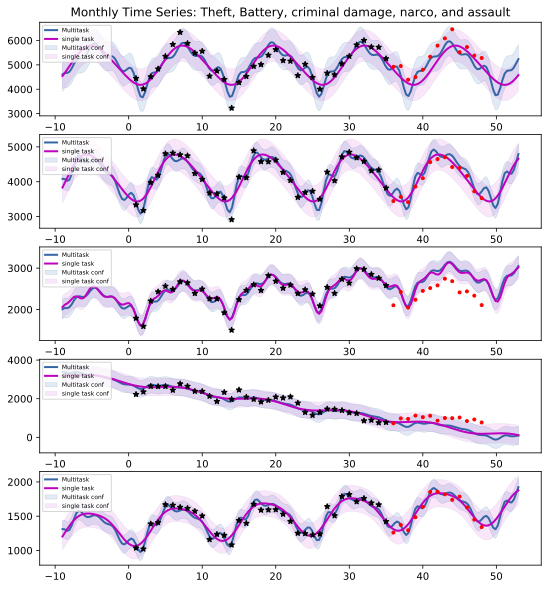

In [115]:
fig = pb.figure(figsize=(9,10))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)
ax = [ax1, ax2, ax3, ax4, ax5]
ax1.set_title("Monthly Time Series: Theft, Battery, criminal damage, narco, and assault")

for i in range(5):
    limits = (min(model1.trainx[i][:,0])-10, max(model1.testx[i][:,0])+5)
    m1.plot_mean(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask")
    m1.plot_confidence(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask conf")
    
    m_list[i].plot_mean(ax=ax[i], color="m",plot_limits=limits, label="single task")
    m_list[i].plot_confidence(ax=ax[i], color="m",plot_limits=limits, alpha=0.1, label="single task conf")
#     ax[i].plot(X_list[i], Y_list[i], 'k*', label="observed samples")
    ax[i].plot(model1.trainx[i], model1.trainy[i],'k*', alpha=0.8)
    ax[i].plot(model1.testx[i], model1.testy[i],'r.')
    ax[i].legend(loc=2, prop={'size': 6})

Same thing for weekly.

In [75]:
model2 = timeseries(data)

The prioir for weekly period is 50, and it follows a similar process as the monthly

In [78]:
m_list2 = []
k = 5
model2.weekly(k)

for i in range(k):
    gamma_prior = GPy.priors.Gamma.from_EV(50, 5)
    kernel = GPy.kern.StdPeriodic(1)+GPy.kern.Linear(1)+GPy.kern.White(1)
    m = GPy.models.GPRegression(model2.trainx[i],model2.trainy[i],kernel=kernel, normalizer=True)
    m.sum.std_periodic.period.set_prior(gamma_prior)
    m.optimize_restarts(num_restarts = 5)
    m_list2.append(m)

reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 152.10908801091946
Optimization restart 2/5, f = 152.10909092719427
Optimization restart 3/5, f = 152.109080718441
Optimization restart 4/5, f = 152.1090788122731


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 152.10909748646122
Optimization restart 1/5, f = 145.6622275959046
Optimization restart 2/5, f = 145.66222752422198
Optimization restart 3/5, f = 145.66222752519008
Optimization restart 4/5, f = 145.66222752717542


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 145.66222752314155
Optimization restart 1/5, f = 157.5876334830876
Optimization restart 2/5, f = 157.58763348254115
Optimization restart 3/5, f = 157.587633482883
Optimization restart 4/5, f = 157.5876334823626


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 157.58763349041192
Optimization restart 1/5, f = 100.30794415946205
Optimization restart 2/5, f = 100.30794395208072
Optimization restart 3/5, f = 100.30794395305648
Optimization restart 4/5, f = 100.30794396557951


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 100.30794399311695
Optimization restart 1/5, f = 151.63270085069098
Optimization restart 2/5, f = 151.63270084222094
Optimization restart 3/5, f = 151.63270087054806
Optimization restart 4/5, f = 151.63270088766504
Optimization restart 5/5, f = 151.63270084111653


Multitask for weekly

In [77]:
K = GPy.kern.StdPeriodic(1, period=12)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
KK = GPy.kern.StdPeriodic(1, period=4)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
K1 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
K2 = GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
K3 = GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
# lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=5,kernels_list=[K, K1,K2, K3])
kernel=K+K1+K2+K3

X = process_multitask(model2.trainx)
Y = process_multitask(model2.trainy)[:,0][:, None]

m2 = GPy.models.GPRegression(X,Y,kernel)
m2.sum.mul.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(50, 5))
m2.sum.mul.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
#m['.*bias.var'].constrain_fixed(1)
#m['.*W'].constrain_fixed(0)
m2.optimize_restarts(5)
print(m2)

reconstraining parameters GP_regression.sum.mul.std_periodic.period
reconstraining parameters GP_regression.sum.mul.std_periodic.lengthscale


Optimization restart 1/5, f = 4191.35453899075
Optimization restart 2/5, f = 4191.354368602845
Optimization restart 3/5, f = 4191.355878004465
Optimization restart 4/5, f = 4183.9792260145505
Optimization restart 5/5, f = 4191.352553077439

Name : GP regression
Objective : 4183.9792260145505
Number of Parameters : 67
Number of Optimization Parameters : 67
Updates : True
Parameters:
  GP_regression.                    |              value  |  constraints  |     priors    
  sum.mul.std_periodic.variance     |      4.25260051504  |      +ve      |               
  sum.mul.std_periodic.period       |      52.3999187716  |      +ve      |  Ga(5e+02, 10)
  sum.mul.std_periodic.lengthscale  |     0.305512597197  |      +ve      |  Ga(3.2, 2.1) 
  sum.mul.coregion.W                |             (5, 5)  |               |               
  sum.mul.coregion.kappa            |               (5,)  |      +ve      |               
  sum.mul_1.bias.variance           |        112.9987361  |      +ve 

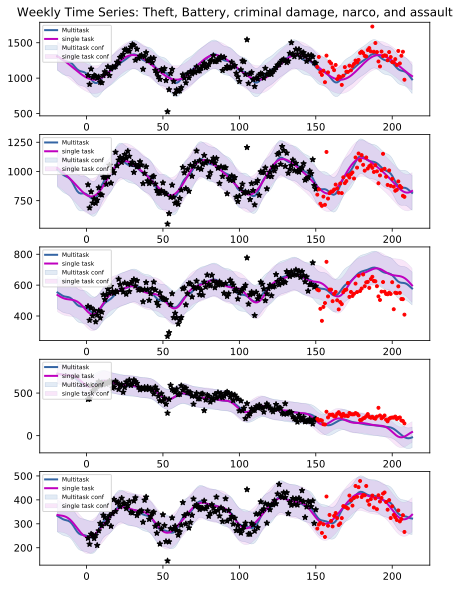

In [79]:
fig = pb.figure(figsize=(7,10))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)
ax = [ax1, ax2, ax3, ax4, ax5]
ax1.set_title("Weekly Time Series: Theft, Battery, criminal damage, narco, and assault")

for i in range(5):
    limits = (min(model2.trainx[i][:,0])-20, max(model2.testx[i][:,0])+5)
    m2.plot_mean(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask")
    m2.plot_confidence(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask conf")
    
    m_list2[i].plot_mean(ax=ax[i], color="m",plot_limits=limits, label="single task")
    m_list2[i].plot_confidence(ax=ax[i], color="m",plot_limits=limits, alpha=0.1, label="single task conf")
#     ax[i].plot(X_list[i], Y_list[i], 'k*', label="observed samples")
    ax[i].plot(model2.trainx[i], model2.trainy[i],'k*', alpha=0.8)
    ax[i].plot(model2.testx[i], model2.testy[i],'r.')
    ax[i].legend(loc=2, prop={'size': 6})

Added additional Periiodic kernel to capture some variation within months for more local structure.  

In [459]:
print(m1)


Name : GP regression
Objective : 95.67151430815305
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                  |              value  |  constraints  |     priors    
  sum.std_periodic.variance       |      3.32974846993  |      +ve      |               
  sum.std_periodic.period         |      54.0628860307  |      +ve      |  Ga(5e+02, 10)
  sum.std_periodic.lengthscale    |      1.52411778596  |      +ve      |               
  sum.std_periodic_1.variance     |  3.10163080119e-13  |      +ve      |               
  sum.std_periodic_1.period       |       2.9531969949  |      +ve      |  Ga(3.2, 0.8) 
  sum.std_periodic_1.lengthscale  |      33.2543915603  |      +ve      |               
  sum.linear.variances            |  1.09305981173e-14  |      +ve      |               
  sum.white.variance              |     0.151681115283  |      +ve      |               
  Gaussian_noise.variance         |     0.181952773398  |

In [95]:
m_list3 = []
k = 5
model2.weekly(k)

for i in range(k):
    gamma_prior = GPy.priors.Gamma.from_EV(50, 5)
    kernel = GPy.kern.StdPeriodic(1)+GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1)+GPy.kern.Linear(1)+GPy.kern.White(1)
    m = GPy.models.GPRegression(model2.trainx[i],model2.trainy[i],kernel=kernel, normalizer=True)
    m.sum.std_periodic.period.set_prior(gamma_prior)
    m.optimize_restarts(num_restarts = 5)
    m_list3.append(m)

reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 139.29883997725395
Optimization restart 2/5, f = 137.4377720947109
Optimization restart 3/5, f = 152.1090940252237
Optimization restart 4/5, f = 137.43884139480733


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 137.43777530581713
Optimization restart 1/5, f = 145.23492703442435
Optimization restart 2/5, f = 144.61816579736882
Optimization restart 3/5, f = 144.61811986312762
Optimization restart 4/5, f = 145.66222752340718


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 145.6622050014383
Optimization restart 1/5, f = 152.87654676304777
Optimization restart 2/5, f = 153.01800006198204
Optimization restart 3/5, f = 153.02830968402014
Optimization restart 4/5, f = 154.15580000208791


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 157.58763351832016
Optimization restart 1/5, f = 70.4568422946641
Optimization restart 2/5, f = 70.01621781530679
Optimization restart 3/5, f = 68.43621413987357
Optimization restart 4/5, f = 68.43621476360585
Optimization restart 5/5, f = 68.43621327446016


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 149.50294057741377
Optimization restart 2/5, f = 149.20159660123238
Optimization restart 3/5, f = 149.1964414847306
Optimization restart 4/5, f = 149.19651382624753
Optimization restart 5/5, f = 149.19690947355394


In [117]:
K = GPy.kern.StdPeriodic(1, period=12)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
KK = (GPy.kern.StdPeriodic(1, period=4)*GPy.kern.RBF(1))**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
K1 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
K2 = GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
K3 = GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
# lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=5,kernels_list=[K, K1,K2, K3])
kernel=K+KK+K1+K2+K3

X = process_multitask(model2.trainx)
Y = process_multitask(model2.trainy)[:,0][:, None]

m3 = GPy.models.GPRegression(X,Y,kernel)
m3.sum.mul.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(50, 5))
m3.sum.mul.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
#m['.*bias.var'].constrain_fixed(1)
#m['.*W'].constrain_fixed(0)
m3.optimize(messages=True, max_iters=175)
print(m3)

reconstraining parameters GP_regression.sum.mul.std_periodic.period
reconstraining parameters GP_regression.sum.mul.std_periodic.lengthscale



Name : GP regression
Objective : 4057.8863993426417
Number of Parameters : 102
Number of Optimization Parameters : 102
Updates : True
Parameters:
  GP_regression.                      |            value  |  constraints  |     priors    
  sum.mul.std_periodic.variance       |   0.128545066807  |      +ve      |               
  sum.mul.std_periodic.period         |    50.2772088646  |      +ve      |  Ga(5e+02, 10)
  sum.mul.std_periodic.lengthscale    |    1.11920634053  |      +ve      |  Ga(3.2, 2.1) 
  sum.mul.coregion.W                  |           (5, 5)  |               |               
  sum.mul.coregion.kappa              |             (5,)  |      +ve      |               
  sum.mul_1.std_periodic.variance     |    4.74565126401  |      +ve      |               
  sum.mul_1.std_periodic.period       |      3.838826813  |      +ve      |               
  sum.mul_1.std_periodic.lengthscale  |   0.554266883409  |      +ve      |               
  sum.mul_1.rbf.variance          

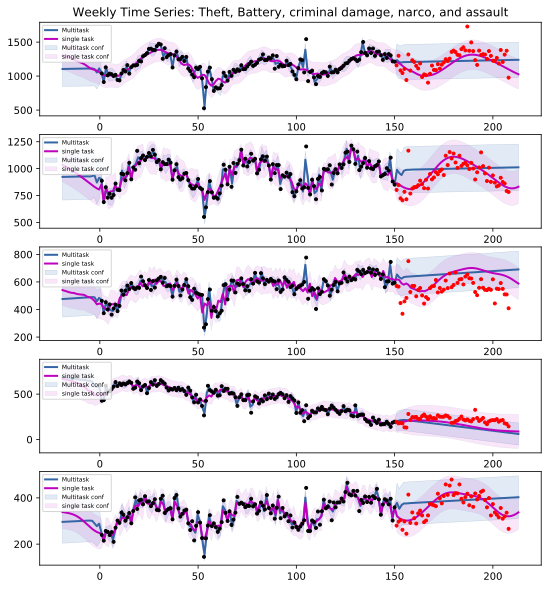

In [118]:
fig = pb.figure(figsize=(9,10))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)
ax = [ax1, ax2, ax3, ax4, ax5]
ax1.set_title("Weekly Time Series: Theft, Battery, criminal damage, narco, and assault")

for i in range(5):
    limits = (min(model2.trainx[i][:,0])-20, max(model2.testx[i][:,0])+5)
    m3.plot_mean(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask")
    m3.plot_confidence(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask conf")
    
    m_list3[i].plot_mean(ax=ax[i], color="m",plot_limits=limits, label="single task")
    m_list3[i].plot_confidence(ax=ax[i], color="m",plot_limits=limits, alpha=0.1, label="single task conf")
#     ax[i].plot(X_list[i], Y_list[i], 'k*', label="observed samples")
    ax[i].plot(model2.trainx[i], model2.trainy[i],'k.', alpha=0.6)
    ax[i].plot(model2.testx[i], model2.testy[i],'r.')
    ax[i].legend(loc=2, prop={'size': 6})

In [119]:
# fig = pb.figure(figsize=(12,20))
# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)
# ax = [ax1, ax2, ax3, ax4, ax5]
# ax1.set_title("Monthly Time Series: Theft, Battery, criminal damage, narco, and assault")

# for i in range(5):
#     ni = theft.known_X.shape[0]
# #     m.plot(plot_limits=(-10,250),fixed_inputs=[(1,i)], which_data_rows=slice(i*ni,(i+1)*ni-1),\
# #            ax=ax[i],legend=(i==0), label="Multitask")
#     m.plot_mean(plot_limits=(-10,250),fixed_inputs=[(1,i)],ax=ax[i], label="Multitask")
#     m.plot_confidence(plot_limits=(-10,250),fixed_inputs=[(1,i)],ax=ax[i], label="Multitask confidence")

#     m_list[i].plot_mean(ax=ax[i], color="m",plot_limits=(-10,250), label="single task", alpha=0.6)
#     m_list[i].plot_confidence(ax=ax[i], color="m",plot_limits=(-10,250), alpha=0.1, label="single task confidence")
#     ax[i].plot(X_list[i], Y_list[i], 'k*', label="observed samples")
#     ax[i].plot(full_X_list[i], full_Y_list[i],'g.', alpha=0.5)
#     ax[i].plot(test_X_list[i], test_Y_list[i],'r.')

Get correlation matrix for tasks.  Different kernsl have different correlation matrices.  This can be called by m.sum.mul_i.coregion.B

In [465]:
B = m.sum.mul_3.coregion.B
print(np.round(B, 2))
print(np.round((B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B)),2))

[[   1.51   -0.83   -5.17   25.81   -2.56]
 [  -0.83    0.45    2.84  -14.17    1.41]
 [  -5.17    2.84   17.73  -88.58    8.8 ]
 [  25.81  -14.17  -88.58  446.99  -43.95]
 [  -2.56    1.41    8.8   -43.95    4.36]]
[[ 1.   -1.   -1.    0.99 -1.  ]
 [-1.    1.    1.   -0.99  1.  ]
 [-1.    1.    1.   -0.99  1.  ]
 [ 0.99 -0.99 -0.99  1.   -0.99]
 [-1.    1.    1.   -0.99  1.  ]]


Attempt at spare GP regression with the same setting as above, but doesn't work as not psd.

In [466]:
# K = GPy.kern.StdPeriodic(1, period=12)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
# KK = GPy.kern.StdPeriodic(1, period=4)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)
# K1 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
# K2 = GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
# K3 = GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)
# # lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=5,kernels_list=[K, K1,K2, K3])
# kernel=K+K1+K2+K3
# X_list = [theft.known_X, battery.known_X, crim.known_X, narc.known_X, assault.known_X]
# Y_list = [theft.known_Y, battery.known_Y, crim.known_Y, narc.known_Y, assault.known_Y]
# X = process_multitask(X_list)
# Y = process_multitask(Y_list)[:,0][:, None]
# Z = np.random.rand(12,1)*160

# m = GPy.models.SparseGPRegression(X, Y, kernel=kernel)
# m.sum.mul.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(50, 5))
# m.sum.mul.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
# #m['.*bias.var'].constrain_fixed(1)
# #m['.*W'].constrain_fixed(0)
# m.optimize_restarts(5)
# print(m)

Using a differrent setup with CoregionalizedRegression.  This is a sum of ICMs as opposed to LCM.  They are essentially the same except we cannot specify the rank for each task kernels.

In [121]:
# K = GPy.kern.StdPeriodic(1)
# KK = GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1)
# K1 = GPy.kern.Bias(1)
# K2 = GPy.kern.Linear(1)
# K3 = GPy.kern.White(1)
# lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=5,kernels_list=[K,KK,K1,K2, K3])

# Z = np.random.rand(12,1)*160

# m = GPy.models.SparseGPCoregionalizedRegression(X_list,Y_list,kernel=lcm)
# #m.randomize()

# m.sum.ICM0.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(52, 5))
# m.sum.ICM0.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
# #m['.*bias.var'].constrain_fixed(1)
# #m['.*W'].constrain_fixed(0)
# m.optimize_restarts(5)


In [120]:
# fig = pb.figure(figsize=(12,20))
# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)
# ax = [ax1, ax2, ax3, ax4, ax5]
# ax1.set_title("Multitask Monthly: Theft, Battery, criminal damage, narco, and assault")

# for i in range(5):
#     ni = theft.X.shape[0]
#     m.plot_mean(plot_limits=(-10,250),fixed_inputs=[(1,i)], ax=ax[i])
#     m.plot_confidence(plot_limits=(-10,250),fixed_inputs=[(1,i)], ax=ax[i])
#     ax[i].plot(X_list[i], Y_list[i],'k*', alpha=0.8)

#     ax[i].plot(full_X_list[i], full_Y_list[i],'g.', alpha=0.5)
#     ax[i].plot(test_X_list[i], test_Y_list[i],'r.')